Imports

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns_general_width   = 16
sns_general_height  = 8
sns.set(rc={'figure.figsize':(sns_general_width, sns_general_height)})

## ETL

Utilities

In [3]:
# Special codes with the exception of Kosovo (OWID_KOS)
special_owid_codes = ('OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM',
       'OWID_CYN', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC', 'OWID_WRL')

In [4]:
def plot_full(countries, df, title, metric, date="date"):
    for country in countries:
        _df = df[df['country'] == country]
        plt.plot(_df[date], _df[metric])
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

def plot_summary(df, title, metric, date='date', remove_mean=False):
    if not remove_mean:
        df = df.groupby(date).agg(
                mean=(metric,"mean"), 
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95)),
                # std=(metric,np.std) # The STD doesn't seem to tell us much
            ).reset_index()
    else:
        df = df.groupby(date).agg(
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95)),
                # std=(metric,np.std) # The STD doesn't seem to tell us much
            ).reset_index()
    # df['plus_1_std'] = df['mean'] + df['std']
    # df['minus_1_std'] = df['mean'] - df['std']
    # df = df.drop(columns=['std'])
    df.plot(df.columns[0], df.columns[1:]) # date vs mean, median, 5th, 95th
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

### Stringency

In [5]:
stringency_df = pd.read_csv('data/stringency/covid-stringency-index.csv')
stringency_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
    
stringency_df.head()

,country,code,date,stringency_index
0,Afghanistan,AFG,2020-01-21,0.0
1,Afghanistan,AFG,2020-01-22,0.0
2,Afghanistan,AFG,2020-01-23,0.0
3,Afghanistan,AFG,2020-01-24,0.0
4,Afghanistan,AFG,2020-01-25,0.0


In [6]:
stringency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138428 entries, 0 to 138427
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           138428 non-null  object 
 1   code              138428 non-null  object 
 2   date              138428 non-null  object 
 3   stringency_index  138428 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


In [7]:
stringency_df.describe()

,stringency_index
count,138428.000000
mean,52.029399
std,22.729767
min,0.000000
25%,37.960000
50%,52.780000
75%,69.440000
max,100.000000


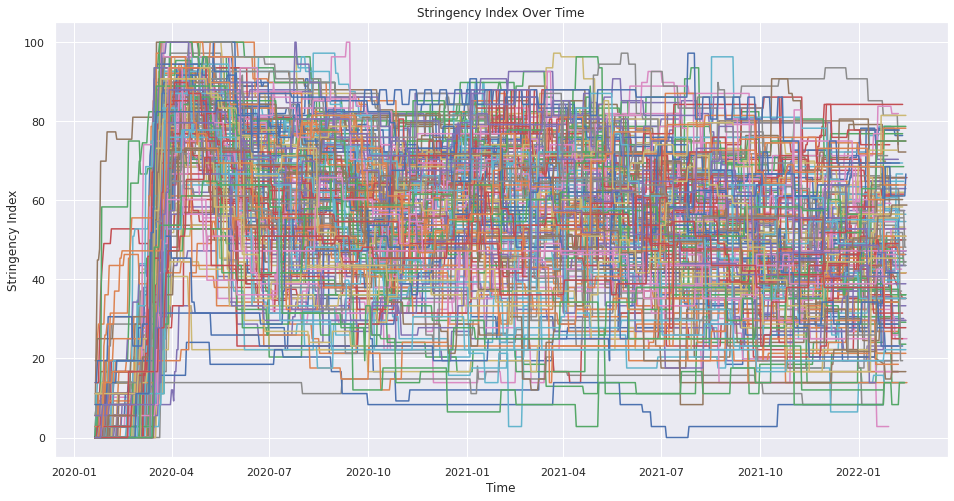

In [8]:
countries = stringency_df['country'].unique()
stringency_df['date'] = pd.to_datetime(stringency_df['date'])
plot_full(countries, stringency_df, title='Stringency Index Over Time', metric='stringency_index')

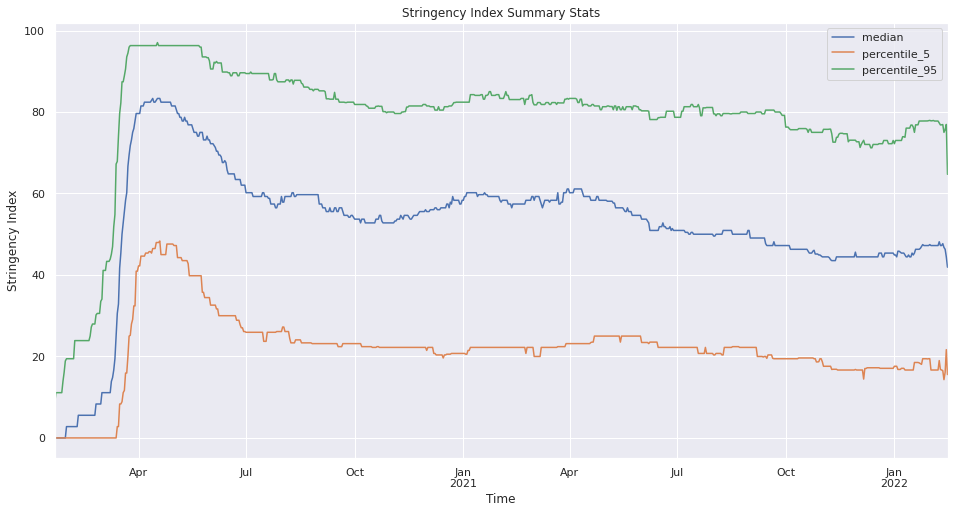

In [9]:
plot_summary(stringency_df, title='Stringency Index Summary Stats', metric='stringency_index', remove_mean=True)

---
Spot the waves and variants

### Containment/Health

In [10]:
containment_health_df = pd.read_csv('data/stringency/covid-containment-and-health-index.csv')
containment_health_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
containment_health_df.head()

,country,code,date,containment_index
0,Afghanistan,AFG,2020-01-01,0.0
1,Afghanistan,AFG,2020-01-02,0.0
2,Afghanistan,AFG,2020-01-03,0.0
3,Afghanistan,AFG,2020-01-04,0.0
4,Afghanistan,AFG,2020-01-05,0.0


In [11]:
containment_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142001 entries, 0 to 142000
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            142001 non-null  object 
 1   code               142001 non-null  object 
 2   date               142001 non-null  object 
 3   containment_index  142001 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


In [12]:
containment_health_df.describe()

,containment_index
count,142001.000000
mean,51.150051
std,20.569953
min,0.000000
25%,41.670000
50%,55.360000
75%,66.070000
max,93.450000


In [13]:
containment_health_df['date'] = pd.to_datetime(containment_health_df['date'])

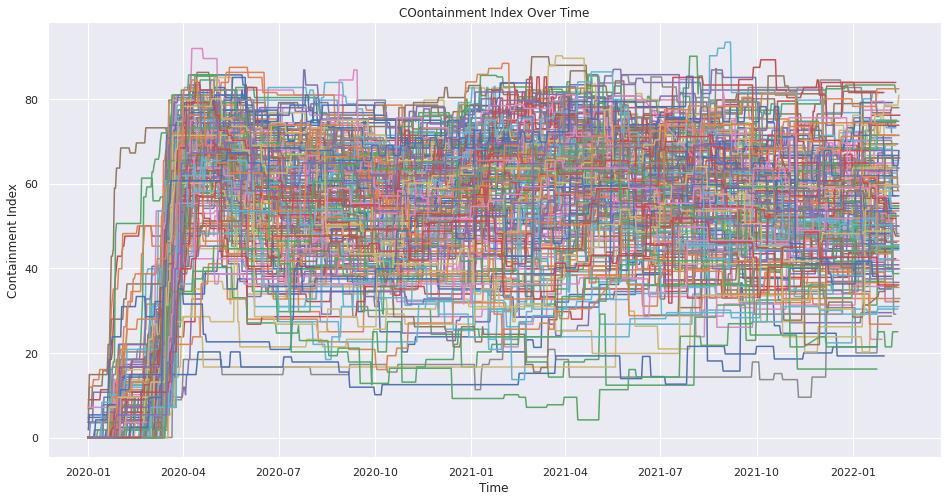

In [14]:
plot_full(countries, containment_health_df, title='COontainment Index Over Time', metric='containment_index')

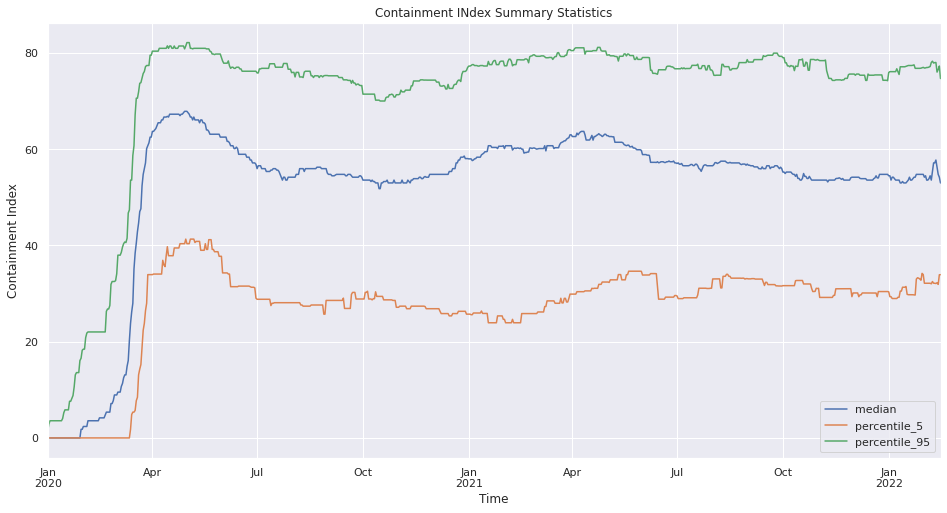

In [15]:
plot_summary(containment_health_df, title='Containment INdex Summary Statistics', metric='containment_index', remove_mean=True)

Cases, deaths, mobility against Stringency/containment  
Pull in mask data too

### Deaths
Deaths can be an intensity metric

In [16]:
covid_history_df = pd.read_csv('data/general/owid-covid-data.csv')
covid_history_df.rename(columns={
    "location":"country",
    "iso_code":"code"},
    inplace=True)

owid_aggregations_df = covid_history_df[covid_history_df['code'].isin(special_owid_codes)]
owid_aggregations_df.rename(columns={
    "country":"category"},
    inplace=True)

covid_history_df = covid_history_df[~covid_history_df['code'].isin(special_owid_codes)].sort_values(by=['code', 'date'])
covid_history_df.head()

,code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
7204,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7205,ABW,North America,Aruba,2020-03-14,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7206,ABW,North America,Aruba,2020-03-15,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7207,ABW,North America,Aruba,2020-03-16,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7208,ABW,North America,Aruba,2020-03-17,3.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN


In [17]:
income_levels = [level for level in owid_aggregations_df["category"].unique() if level.endswith("income")]
income_levels

['High income', 'Low income', 'Lower middle income', 'Upper middle income']

In [18]:
# remove rows for any country before it makes a contribution to the data
def remove_rows_before_contributions():
    for code in covid_history_df.code.unique():
        _df = covid_history_df[covid_history_df['code'] == code]
        for row in _df.itertuples():
            if (row.new_cases == 0 or row.new_cases is None) and (row.total_cases == 0 or row.total_cases is None):
                covid_history_df.drop(index=row.Index, inplace=True)
                break
        continue
remove_rows_before_contributions()

In [19]:
covid_history_df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.494710e+05,1.494310e+05,148357.000000,131999.000000,131974.000000,131916.000000,149471.000000,149431.000000,148357.000000,131999.000000,...,102636.000000,101217.000000,66076.000000,119818.000000,150598.000000,132065.000000,5.520000e+03,5520.000000,5532.000000,5520.000000
mean,6.091378e+05,2.768952e+03,2750.026014,14392.874332,44.023565,43.808731,27436.963204,157.789241,155.576963,489.620358,...,10.661957,32.757015,50.677561,3.030285,73.582626,0.725585,3.685615e+04,9.213859,15.987232,924.226535
std,3.036980e+06,1.768855e+04,16699.080456,57807.687560,194.868409,183.471101,47135.931057,665.961036,507.182242,769.256198,...,10.593430,13.568759,31.974186,2.458626,7.511894,0.150416,1.027585e+05,16.497870,30.375823,1373.111371
min,1.000000e+00,-7.493700e+04,-6223.000000,1.000000,-1918.000000,-232.143000,0.001000,-13876.282000,-1936.106000,0.001000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-3.772610e+04,-28.450000,-95.920000,-1826.595723
25%,1.613000e+03,0.000000e+00,5.714000,68.000000,0.000000,0.143000,553.505500,0.000000,1.429000,16.556000,...,1.900000,21.600000,19.351000,1.300000,69.020000,0.602000,-8.922500e+01,-0.890000,-0.830000,-37.027419
50%,1.902600e+04,6.000000e+01,82.571000,610.000000,1.000000,1.857000,4332.005000,9.724000,16.433000,113.443000,...,6.300000,31.400000,49.542000,2.397000,75.050000,0.744000,3.217500e+03,5.755000,7.130000,436.789598
75%,2.167640e+05,7.420000e+02,795.429000,5047.000000,13.000000,14.000000,35257.099000,96.151500,113.788000,672.234000,...,19.300000,41.300000,83.241000,4.000000,78.950000,0.845000,2.413720e+04,14.300000,22.947500,1578.960127
max,7.803635e+07,1.368563e+06,802374.000000,925435.000000,4529.000000,4190.000000,611787.251000,51427.491000,16052.608000,6249.090000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,1.080748e+06,111.010000,374.600000,8626.892312


In [20]:
covid_history_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152105 entries, 7204 to 162143
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        152105 non-null  object 
 1   continent                                   152105 non-null  object 
 2   country                                     152105 non-null  object 
 3   date                                        152105 non-null  object 
 4   total_cases                                 149471 non-null  float64
 5   new_cases                                   149431 non-null  float64
 6   new_cases_smoothed                          148357 non-null  float64
 7   total_deaths                                131999 non-null  float64
 8   new_deaths                                  131974 non-null  float64
 9   new_deaths_smoothed                         131916 non-null  float6

Deaths per million

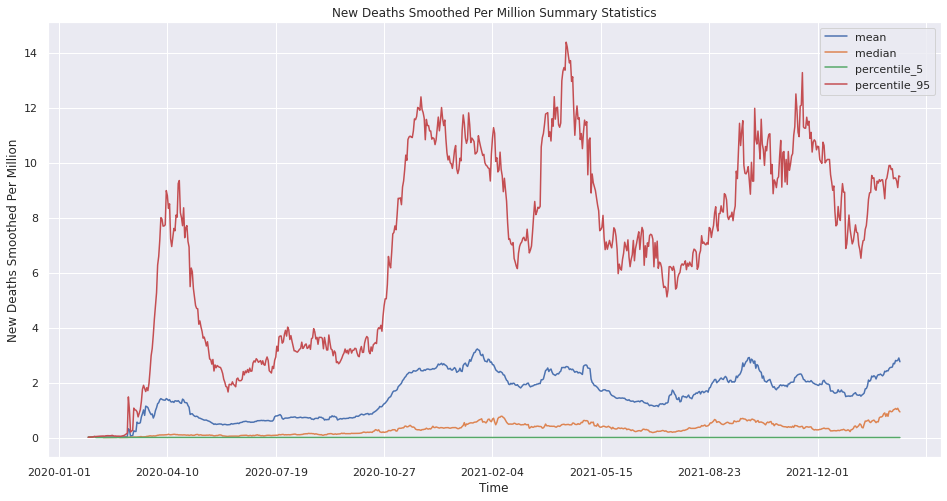

In [21]:
plot_summary(covid_history_df, title='New Deaths Smoothed Per Million Summary Statistics', metric="new_deaths_smoothed_per_million")

Mortality

In [22]:
# Align the zeros of the two y-axes
# Adapted from: https://stackoverflow.com/a/54355867/6712832
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

(0.0, 75.0)

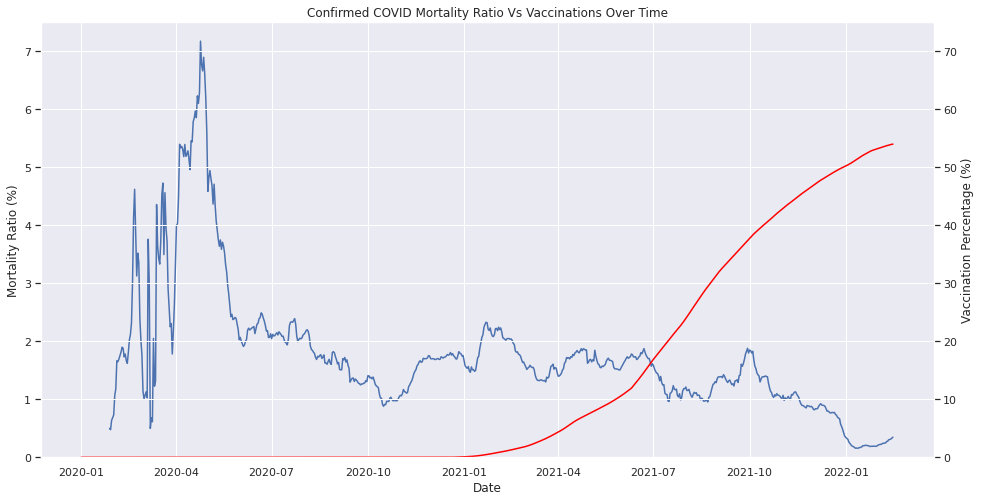

In [23]:
mortality_df = covid_history_df.groupby('date').agg('sum').reset_index()
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
fig, ax = plt.subplots()

ax.plot(mortality_df['date'], 100*mortality_df['new_deaths_smoothed_per_million']/mortality_df['new_cases_smoothed_per_million'], label='Mortality Ratio')
ax.set_title('Confirmed COVID Mortality Ratio Vs Vaccinations Over Time')
ax.set_ylabel('Mortality Ratio (%)')
ax.set_xlabel('Date')

ax_twin = ax.twinx()
ax_twin.plot(mortality_df['date'], 100*np.cumsum(mortality_df['new_people_vaccinated_smoothed'])/mortality_df['population'], color='red', label='Vaccination Percentage')

ax_twin.set_ylabel('Vaccination Percentage (%)')
# align_yaxis(ax, ax_twin)
ax.set_ylim([0, 7.5])
ax_twin.set_ylim([0, 75])

# Standard error froo mortality ratio. Formula here: https://www.statology.org/standard-error-of-proportion/


In [24]:
selected_columns = [col for col in covid_history_df.columns if (
                ("_per_" in col or "smoothed" in col) and ("cases" in col or "deaths" in col) and ("total" not in col)
                )]+['stringency_index']

In [26]:
# sns.heatmap(covid_history_df[selected_columns].corr(), annot=True)
# plt.title("Correlation matrix for smoothed and normalized features with Stringency Index")

### Mobility

In [30]:
mobility_df = pd.read_csv("data/mobility/changes-visitors-covid.csv")
mobility_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(covid_history_df, mobility_df, how="outer", on=["country", "code", "date"])

In [228]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155412 entries, 0 to 155411
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        155412 non-null  object 
 1   continent                                   152105 non-null  object 
 2   country                                     155412 non-null  object 
 3   date                                        155412 non-null  object 
 4   total_cases                                 149471 non-null  float64
 5   new_cases                                   149431 non-null  float64
 6   new_cases_smoothed                          148357 non-null  float64
 7   total_deaths                                131999 non-null  float64
 8   new_deaths                                  131974 non-null  float64
 9   new_deaths_smoothed                         131916 non-null  float64
 

In [32]:
# Making sure that stringency_index stays at the end of the column list after adding mobility
selected_columns = selected_columns[:-1] + list(merged_df.columns[-6:]) + ['stringency_index']

In [31]:
# sns.heatmap(merged_df[selected_columns].corr(), annot=True)
# plt.title("Correlation matrix for smoothed and normalized features with Mobility and Stringency Index")

Change in correlations over time

In [33]:
selected_columns

['new_cases_smoothed',
 'new_deaths_smoothed',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'retail_and_recreation',
 'grocery_and_pharmacy',
 'residential',
 'transit_stations',
 'parks',
 'workplaces',
 'stringency_index']

In [36]:
max(merged_df['date'])

'2022-02-15'

North America
South America
Asia
Europe
Oceania
Africa


Text(0, 0.5, 'Correlation of Residential Mobility and Stringency Index')

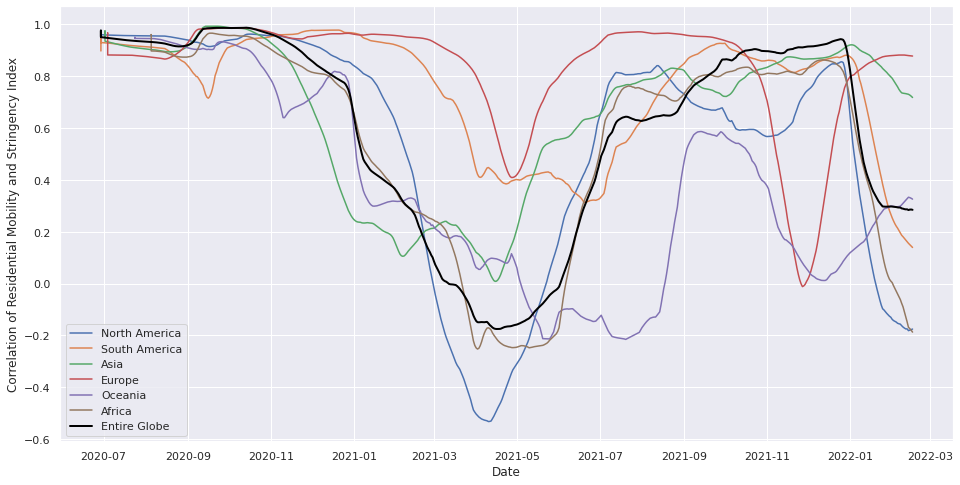

In [51]:
# df_for_windows = merged_df[merged_df['country'] == 'United States'][['date']+selected_columns[-7:]]
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 180 # Averaging window of 6 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent) # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        for window in df_for_windows[df_for_windows['continent']==continent].rolling(window=rolling_window):
            # if len(window) > 0:
            residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(window['date'].iloc[0] + timedelta(days=rolling_window))
        plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label=continent)
        
residential_corr = []
end_dates = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    # if len(window) > 0:
    residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
    end_dates.append(list(window['date'])[0] + timedelta(days=rolling_window))
plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Entire Globe", color="black", linewidth=2)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Correlation of Residential Mobility and Stringency Index")

In [234]:
covid_history_df[covid_history_df['country'] == 'United States']

,code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
153274,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153275,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153276,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153277,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153278,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154025,USA,North America,United States,2022-02-11,77650446.0,209265.0,187509.143,918818.0,2604.0,2338.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154026,USA,North America,United States,2022-02-12,77705598.0,55152.0,180461.429,919622.0,804.0,2324.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154027,USA,North America,United States,2022-02-13,77762374.0,56776.0,177070.714,920063.0,441.0,2331.000,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154028,USA,North America,United States,2022-02-14,77925899.0,163525.0,152034.429,922840.0,2777.0,2309.857,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN


Optimizing lag

In [235]:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df[merged_df['country'] == 'United States']['stringency_index'].corr(merged_df[merged_df['country'] == 'United States']['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.7330011450912292


In [236]:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df[merged_df['country'] == 'United Kingdom']['stringency_index'].corr(merged_df[merged_df['country'] == 'United Kingdom']['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.8181370757644617


Correlations of Residential Mobility Against Stringency Index Over Time By Country 


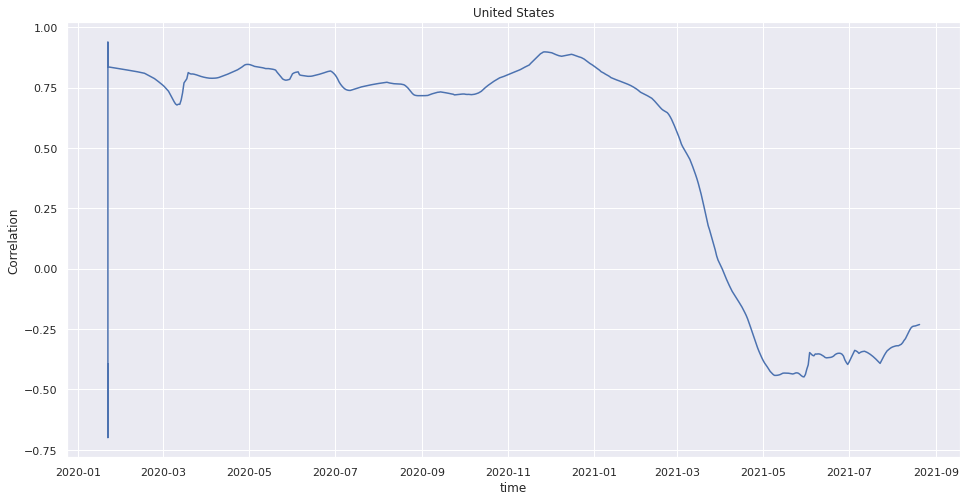

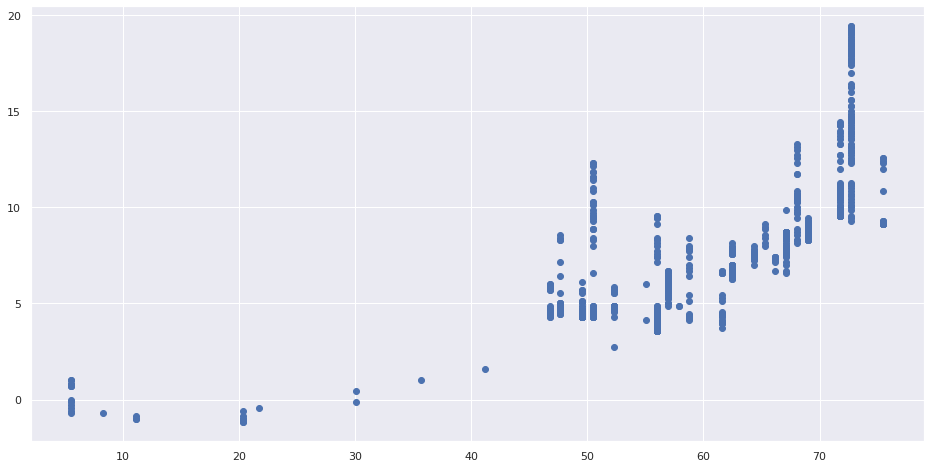

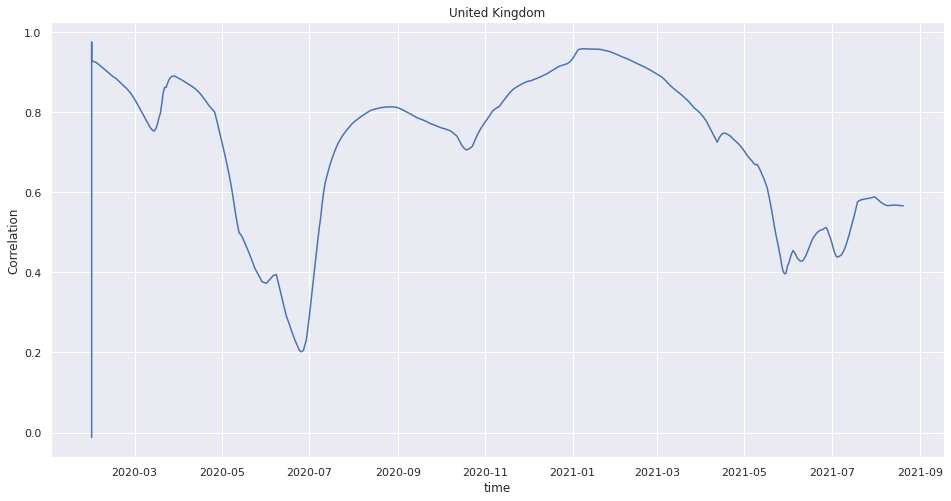

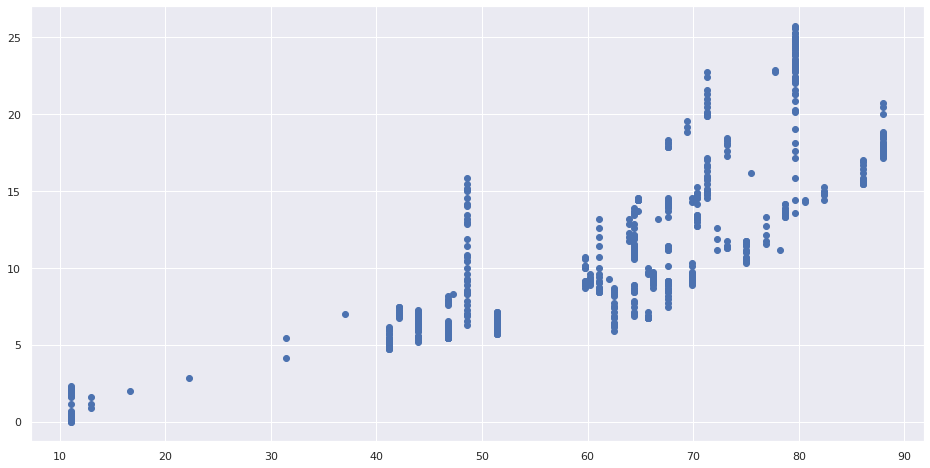

In [237]:
df_for_windows = merged_df[['date', 'country']+selected_columns[-7:]]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

df_for_windows = df_for_windows.groupby(['date', 'country']).agg('mean').reset_index()

# fig, axs = plt.subplots(48, 5, constrained_layout=True)
# fig.set_figheight(15)
# fig.set_figwidth(15)

print('Correlations of Residential Mobility Against Stringency Index Over Time By Country ')
countries = ['United States', 'United Kingdom']
end_iteration = False

for country in countries:
    residential_corr = []
    end_dates = []
    for window in df_for_windows[df_for_windows['country']==country].rolling(window=180):
        if len(window) > 0:
            residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(list(window['date'])[0])
    plt.plot(end_dates, residential_corr, label="residential")
    plt.xlabel('time')
    plt.ylabel('Correlation')
    plt.title(country)
    plt.show()

    plt.scatter(df_for_windows[df_for_windows['country']==country]['stringency_index'], df_for_windows[df_for_windows['country']==country]['residential'])
    # plt.plot(np.polyfit(df_for_windows[df_for_windows['country']==country]['stringency_index'], df_for_windows[df_for_windows['country']==country]['residential'], 1), color='red')
    plt.show()

In [239]:
len(df_for_windows)

155412

#### Stringency Vs Deaths

#### Stringency Vs Cases

#### Stringency Vs Mobility

### Mobility vs Deaths

---


### Headline
* Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
* Mortality ratio (Derived from cases and deaths) - how deadly is it?
* Stringency over time  - how are governments responding?
* Mobility over time - how are people reacting?


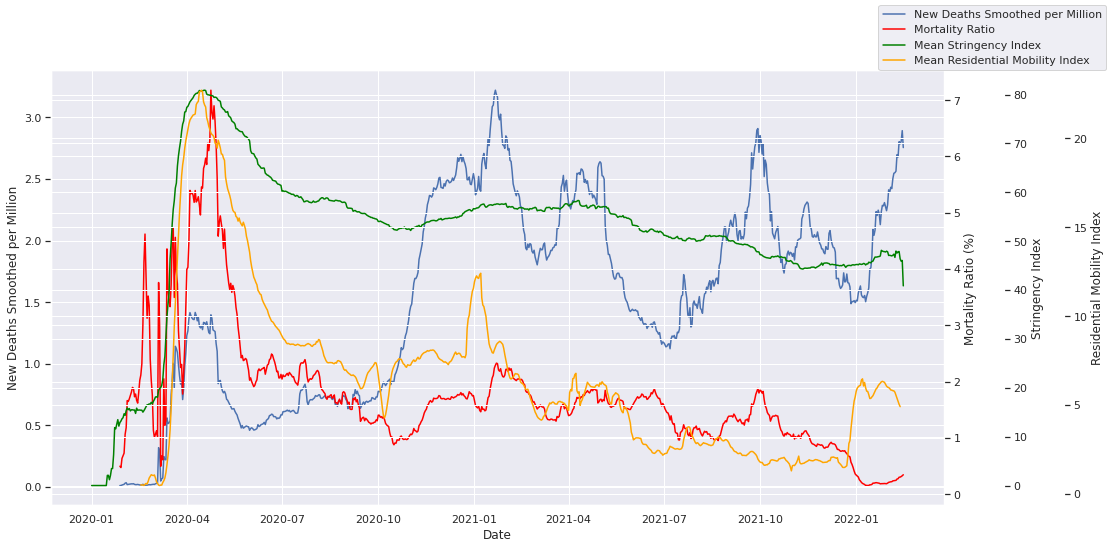

In [245]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_mortality_ratio = ax.twinx()
ax_twin_mortality_ratio.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio', color='red')
ax_twin_mortality_ratio.set_ylabel('Mortality Ratio (%)')

# Stringency over time  - how are governments responding?
ax_twin_stringency = ax.twinx()
ax_twin_stringency.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index', color='green')
ax_twin_stringency.spines['right'].set_position(('outward', 60))
ax_twin_stringency.set_ylabel("Stringency Index")

ax_twin_residential_mobility = ax.twinx()
ax_twin_residential_mobility.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index', color='orange')
ax_twin_residential_mobility.spines['right'].set_position(('outward', 120))
ax_twin_residential_mobility.set_ylabel("Residential Mobility Index")



fig.legend()

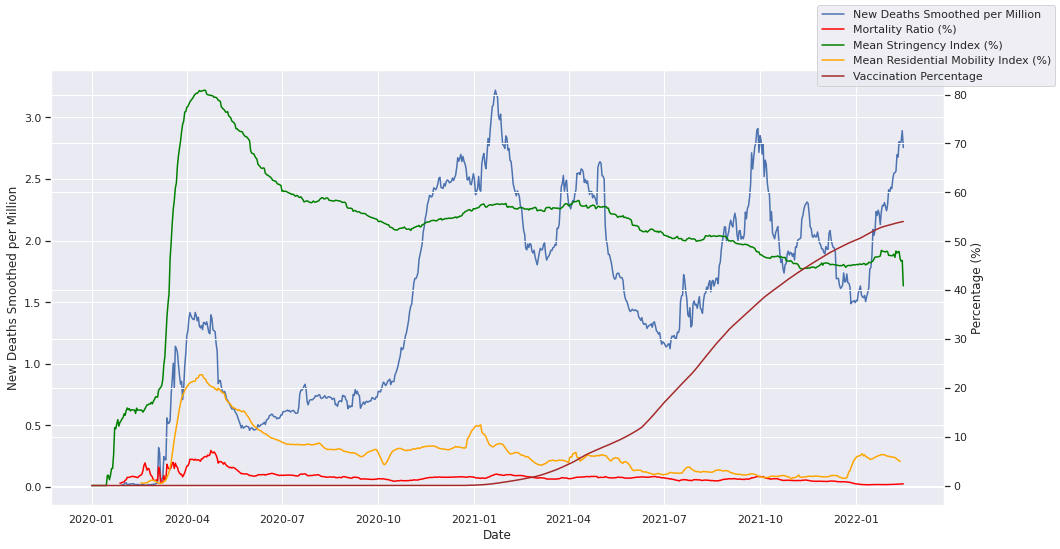

In [246]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_percentages = ax.twinx()
ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
ax_twin_percentages.set_ylabel('Percentage (%)')

# Stringency over time  - how are governments responding?
ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index (%)', color='green')

ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

fig.legend()

In [247]:
covid_history_df[covid_history_df['date']=='2020-03-01']

,code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
6,AFG,Asia,Afghanistan,2020-03-01,5.0,0.0,0.714,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
1462,ALB,Europe,Albania,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
151810,ARE,Asia,United Arab Emirates,2020-03-01,21.0,0.0,1.143,NaN,NaN,NaN,...,1.2,37.4,NaN,1.20,77.97,0.890,NaN,NaN,NaN,NaN
5770,ARG,South America,Argentina,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,...,16.2,27.7,NaN,5.00,76.67,0.845,NaN,NaN,NaN,NaN
6487,ARM,Asia,Armenia,2020-03-01,1.0,1.0,NaN,NaN,NaN,NaN,...,1.5,52.1,94.043,4.20,75.09,0.776,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144646,THA,Asia,Thailand,2020-03-01,42.0,0.0,1.000,1.0,1.0,0.143,...,1.9,38.8,90.670,2.10,77.15,0.777,NaN,NaN,NaN,NaN
142514,TWN,Asia,Taiwan,2020-03-01,40.0,1.0,1.714,1.0,0.0,0.000,...,NaN,NaN,NaN,NaN,80.46,NaN,NaN,NaN,NaN,NaN
153313,USA,North America,United States,2020-03-01,32.0,7.0,2.286,1.0,0.0,0.143,...,19.1,24.6,NaN,2.77,78.86,0.926,-13621.6,-2.48,0.10,-40.916141
158111,VNM,Asia,Vietnam,2020-03-01,16.0,0.0,0.000,NaN,NaN,NaN,...,1.0,45.9,85.847,2.60,75.40,0.704,NaN,NaN,NaN,NaN
